# 기계 번역 모델 학습 

이번 실습에서는 기계 번역을 수행하는 RNN 기반 모델의 학습에 대하여 살펴보겠습니다.

기계 번역이란 하나의 언어로 적혀져있는 문장을 다른 언어의 문장으로 번역하는 분야를 뜻합니다.

룰에 따라 번역을 하는 단순한 기계 번역부터 딥러닝 모델을 이용한 최신 모델까지 다양하게 있습니다.

이번 실습에서는 딥러닝 모델 중 그 기초가 되는 RNN을 이용한 Sequence to Sequence 모델을 만들겠습니다.

그리고 이를 영어-한국어 병렬 데이터를 이용하여 학습하는 것까지 진행하겠습니다.

## 데이터 파일 다운로드

데이터 파일을 다운로드 하기 위해 특수 명령어인 gdown을 사용하였습니다.

기계 번역 학습을 위해서는 한 언어로 적혀진 문장과 같은 뜻을 가진 다른 언어로 적혀진 문장이 필요합니다.

그렇기에 이러한 데이터를 병렬 데이터라고 부릅니다.

예를 들어 아래와 같은 문장들이 데이터입니다.

- 영어: Sign here please.

- 한국어: 여기에 서명하세요.

이러한 데이터를 통해 기계 번역 모델은 학습을 합니다.

그리고 테스트 때 새로운 문장을 받으면 그에 해당하는 다른 언어의 문장으로 바꿔야 합니다.

- 입력: Do you understand?

- 출력: 이해하니?

이러한 병렬 데이터는 여러 있지만 이번 실습에서는 영화와 TV 자막으로 구축한 데이터인 `OpenSubtitles`를 사용하겠습니다.

데이터 출처: https://opus.nlpl.eu/OpenSubtitles2018.php

In [ ]:
!gdown --id 1DGeE1UY8nAhlYwLIIyNRHJ-SlVaxcURU

!gdown --id 1GPUgAlDKn0Wk1TqILJwzqeS84eBiOngU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1DGeE1UY8nAhlYwLIIyNRHJ-SlVaxcURU
To: /content/train_en_ko.csv
100% 145k/145k [00:00<00:00, 61.7MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GPUgAlDKn0Wk1TqILJwzqeS84eBiOngU
To: /content/valid_en_ko.csv
100% 72.5k/72.5k [00:00<00:00, 70.4MB/s]


`train_en_ko.csv` 파일을 열어보면 한 라인에 두 개의 열이 있습니다. 

첫 번째 열에는 영어 문장이 적혀있고 두 번째 열에는 그 문장과 같은 뜻을 가지는 한국어 문장이 있습니다.

이렇게 병렬로 문장이 데이터로 있는 것을 알 수 있습니다.

In [ ]:
with open("train_en_ko.csv") as csv_f:
    head = "\n".join([next(csv_f) for x in range(5)])
print(head)

"Through the snow and sleet and hail, through the blizzard, through the gales, through the wind and through the rain, over mountain, over plain, through the blinding lightning flash, and the mighty thunder crash,","폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘몰아쳐도"

"ever faithful, ever true, nothing stops him, he'll get through.",우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!

Look out for Mr Stork That persevering chap,황새 아저씨를 기다리세요

He'll come along and drop a bundle in your lap,찾아와 선물을 주실 거예요

You may be poor or rich It doesn't matter which,가난하든 부자이든 상관이 없답니다



## 라이브러리 로드

코드 실행에 필요한 라이브러리를 설치하고 로드합니다.

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 32.3 MB/s 
     |████████████████████████████████| 448 kB 35.5 MB/s 


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim
from nltk.tokenize import word_tokenize
import os
import nltk
import codecs
import csv
from konlpy.tag import Okt
import torch.nn.functional as F
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True


## 모델 클래스 정의

pytorch는 딥러닝 모델의 forward path를 정의할 때는 반드시 `nn.Module` 클래스로부터 상속을 받아 새로운 클래스로 만들어야 합니다.

그리고 그 forward path를 정의하기 위해 반드시 `forward` 함수를 정의하여야 합니다.

이번 실습에서는 RNN을 이용한 기계 번역 모델이기에 그에 적합한 클래스를 작성하였습니다.

- 문제 1. `GRUMT` 클래스 내 model 구성에 있어 RNN으로 GRU를 사용하겠습니다. `encoder_rnn`과 `decoder_rnn`에 GRU를 정의하세요.
  - 힌트 1) GRU의 크기는 `hidden_size`에 맞춰주세요.
  - 힌트 2) 간단히 한 방향으로만 움직이는 GRU를 만들어주세요.

In [ ]:
class GRUMT(nn.Module):
    # GRU 기반 MT 클래스를 정의합니다. Pytorch는 모델을 구성할 때 반드시 nn.Module 클래스를 상속받은 후 이를 토대로 만듭니다.
    def __init__(self, input_size, hidden_size, output_size, max_length, device, dropout_p=0.1):
        # 클래스의 첫 시작인 함수입니다. 여기서 모델에 필요한 여러 변수들을 정의합니다.
        super(GRUMT, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.device = device

        # Encoder 부분
        self.encoder_embedding = nn.Embedding(input_size, hidden_size)
        # <ToDo>: encoder를 GRU로 정의하세요.
        self.encoder_rnn = nn.GRU(self.hidden_size, self.hidden_size, bidirectional=False)

        # Decoder 부분
        # <ToDo>: decoder를 GRU로 정의하세요.
        self.decoder_embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.decoder_rnn = nn.GRU(self.hidden_size, self.hidden_size, bidirectional=False)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        self.loss = nn.NLLLoss()

    def _encoder(self, input_tensor, input_length):
        # forward 함수 중 첫 번째 부분인 encoder에 대한 함수입니다.
        encoder_hidden = self._init_hidden()

        encoder_outputs = torch.zeros(self.max_length, self.hidden_size, device=self.device)

        # input_tensor의 길이만큼 하나씩 GRU를 통과시키고 그 결과를 저장합니다.
        for idx in range(input_length):
            input_tensor_step = input_tensor[idx]
            embedded = self.encoder_embedding(input_tensor_step).view(1, 1, -1)
            encoder_output, encoder_hidden = self.encoder_rnn(embedded, encoder_hidden)
            encoder_outputs[idx] = encoder_output[0, 0]

        return encoder_outputs, encoder_hidden

    def _decoder(self, target_tensor, target_length, encoder_hidden, encoder_outputs):
        # forward 함수 중 두 번째 부분인 decoder에 대한 함수입니다.
        # decoder의 입력은 특수 문자인 SOS입니다.
        decoder_input = torch.tensor([[SOS_token]], device=self.device)
        decoder_hidden = encoder_hidden

        loss_sum = 0
        # 번역할 문장의 길이만큼 단어를 생성합니다. 
        # 단어 생성은 주어진 언어 사전에 있는 단어 중 하나를 선택하는 classification 문제와 동일합니다.
        for di in range(target_length):
            embedded = self.decoder_embedding(decoder_input).view(1, 1, -1)
            embedded = self.dropout(embedded)

            # encoder의 결과와 decoder의 hidden을 결합하여 현재 생성할 단어에 영향을 많이 주는 attention을 구합니다.
            decoder_attention = F.softmax(self.attn(torch.cat((embedded[0], decoder_hidden[0]), 1)), dim=1)
            attn_applied = torch.bmm(decoder_attention.unsqueeze(0), encoder_outputs.unsqueeze(0))

            output = torch.cat((embedded[0], attn_applied[0]), 1)
            output = self.attn_combine(output).unsqueeze(0)

            output = F.relu(output)
            output, decoder_hidden = self.decoder_rnn(output, decoder_hidden)

            decoder_output = F.log_softmax(self.out(output[0]), dim=1)

            # decoder를 거쳐 나온 출력 중 가장 높은 값을 가지는 단어를 찾습니다.
            # 찾은 단어는 다음 반복문의 입력 단어가 됩니다.
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            target_output = torch.tensor([target_tensor[di]], device=self.device)
            
            # 그리고 그 단어와 실제 단어의 차이를 loss로 정의합니다.
            loss_sum += self.loss(decoder_output, target_output)
            if decoder_input.item() == EOS_token:
                break

        return loss_sum

    def forward(self, input_tensor, input_length, target_tensor, target_length):
        # 모델의 forward feed를 수행하는 함수입니다.
        # 영어 문장과 한국어 문장 두 개를 받아 영어 문장에서 한국어 문장을 만드는 seq2seq 모델입니다.
        # Encoder 파트
        encoder_outputs, encoder_hidden = self._encoder(input_tensor, input_length)

        # Decoder 파트
        loss_sum = self._decoder(target_tensor, target_length, encoder_hidden, encoder_outputs)

        return loss_sum

    def _init_hidden(self):
        # encoder와 decoder 둘 다 처음에 가지는 hidden입니다. 간단히 0으로 시작합니다.
        return torch.zeros(1, 1, self.hidden_size, device=self.device)

## 데이터 클래스 정의

이번 실습에서는 데이터를 불러올 때 토큰을 만들 수 있도록 데이터 클래스와 이를 만드는 함수 `make_data_loader`를 정의하겠습니다.

이에 앞서 언어별 단어 사전을 만드는 클래스를 정의하여 사용하겠습니다.

이전 실습에서는 `Field` 내 `build_vocab` 함수를 통해 단어 사전을 만들었습니다. 이를 이번에는 직접 구현해보도록 하겠습니다.

단어 사전을 만들 때 있어 기본적으로 가지는 특수한 단어는 3개가 있습니다.

- SOS: Start of the sentence, 문장의 시작을 알리는 단어
- EOS: End of the sentence, 문장의 끝을 알리는 단어
- UNK: Unknown word, 모르는 단어

SOS와 EOS는 각각 문장의 처음과 끝을 알리는 단어입니다.

decoder는 SOS를 처음 입력으로 받아 그로부터 문장 생성을 시작합니다.

그리고 EOS를 생성하게 되면 단어 생성을 멈추는 것입니다.

UNK는 모르는 단어로 out of vocabulary를 표현할 때 사용합니다.

즉, training 데이터에는 나타나지 않지만 validation 혹은 test 데이터에 나타난 단어가 있을 때 그 단어에 대한 표시를 하는 것입니다.

이러한 단어를 무시하는 것도 하나의 방법입니다. 하지만 그런 경우 모르는 단어가 존재한다는 정보가 사라지기에 이를 보완하고자 특수 단어로 표시하는 것입니다.

In [ ]:
class LangDic:
    # 언어마다 단어 사전을 정의합니다.
    def __init__(self, name, tokenizer):
        # 클래스의 첫 시작인 함수입니다. 여기서 모델에 필요한 여러 변수들을 정의합니다.
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 2
        self.tokenizer = tokenizer

    def add_sentence(self, sentence):
        # 문장을 받아 문장에서 단어를 확인합니다.
        for word in self.tokenizer(sentence):
            self.add_word(word)

    def add_word(self, word):
        # 단어를 보고 그 단어가 사전에 존재하는지 아닌지를 살펴봅니다.
        # 존재하지 않는 경우 단어를 사전에 등록합니다.
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def sentence2tensor(self, sentence, max_len):
        # 가지고 있는 사전을 바탕으로 문장을 tensor의 형태로 바꿉니다.
        # tensor 내 들어있는 값은 단어 index이며 이를 통해 모델의 임베딩에 입력으로 줄 수 있습니다.
        indexes = list()
        for word in self.tokenizer(sentence):
            try:
                indexes.append(self.word2index[word])
            except KeyError:
                indexes.append(UNK_token)

        indexes.append(EOS_token)
        len_sen = len(indexes)
        if len_sen > max_len:
            indexes = indexes[:max_len-1]
            indexes.append(EOS_token)
            len_sen = max_len

        index_tensor = torch.tensor(indexes)
        return index_tensor, len_sen

In [ ]:
def make_dic(dataset_path):
    # 사전을 만드는 함수입니다.
    data_pairs = load_file(dataset_path)

    # 영어의 경우 NLTK tokenizer를
    # 한국어의 경우 Konlpy 내 Open Korean Text tokenizer를 이용합니다.
    eng_tokenizer = word_tokenize
    kor_tokenizer = Okt().morphs

    eng_dic = LangDic('en', eng_tokenizer)
    kor_dic = LangDic('ko', kor_tokenizer)

    for eng_sen, kor_sen in data_pairs:
        eng_dic.add_sentence(eng_sen)
        kor_dic.add_sentence(kor_sen)

    return eng_dic, kor_dic

def load_file(dataset_path):
    # 데이터를 읽는 함수입니다.
    data_pairs = list()
    # 데이터 파일의 내용을 불러와 영어 문장과 한국어 문장을 모아 리스트에 넣습니다.
    with codecs.open(dataset_path, "r", "utf-8") as csv_f:
        csv_reader = csv.reader(csv_f)
        for one_row in csv_reader:
            data_pairs.append(one_row)

    return data_pairs

In [ ]:
class MTDataset(Dataset):
    # pytorch로 데이터를 불러오기 위해서 Dataset 클래스를 상속받아 새로운 클래스를 만듭니다.
    def __init__(self, data_pairs, eng_dic, kor_dic, max_len):
        super(MTDataset, self).__init__()

        # 데이터를 파일로부터 읽어 이를 전달 받습니다.
        self.max_len = max_len
        self.pair_data = list()

        # 데이터 내 문장을 미리 정의한 사전에 기반하여 tensor로 바꿉니다.
        for eng_sen, kor_sen in data_pairs:
            eng_sen_words, eng_sen_len = eng_dic.sentence2tensor(eng_sen, max_len)
            kor_sen_words, kor_sen_len = kor_dic.sentence2tensor(kor_sen, max_len)
            self.pair_data.append((eng_sen_words, eng_sen_len, kor_sen_words, kor_sen_len))

        self.data_len = len(self.pair_data)

    def __getitem__(self, idx):
        # idx번째 데이터를 반환합니다.
        eng_sen_words, eng_sen_len, kor_sen_words, kor_sen_len = self.pair_data[idx]

        return eng_sen_words, eng_sen_len, kor_sen_words, kor_sen_len

    def __len__(self):
        return self.data_len

In [ ]:
def make_data_loader(dataset_path, eng_dic, kor_dic, max_len, batch_size):
    # DataLoader를 만들어서 데이터를 불러오도록 합니다.
    data_pairs = load_file(dataset_path)

    # 앞서 정의한 MTDataset 클래스에 해당 데이터를 넣습니다.
    ds = MTDataset(data_pairs, eng_dic, kor_dic, max_len)

    # 만들어진 MTDataset 클래스를 DataLoader에 넣고 batch 크기를 전달해줍니다.
    return DataLoader(ds, batch_size=batch_size)

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)


def load_checkpoint(load_path, model, optimizer, device):
    state_dict = torch.load(load_path, map_location=device)

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)


def load_metrics(load_path, device):
    state_dict = torch.load(load_path, map_location=device)

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## train 함수

해당 함수에서는 정의된 `model` 클래스의 인스턴스를 가져와서 이를 train data로 학습시킵니다. 그리고 validation data로 학습 중간에 성능을 평가합니다.

In [ ]:
# 경로 추가
output_file_path="./model/"
os.makedirs(output_file_path, exist_ok=True)

def train(model, device, optimizer, train_loader, valid_loader, num_epochs):
    # 학습에 필요한 변수들을 기본적으로 정의합니다.
    running_loss = 0.0
    global_step = 0
    eval_every = 100
    train_loss_list = list()
    valid_loss_list = list()
    global_steps_list = list()

    # model에게 학습이 진행됨을 알려줍니다.
    model.train()
    # num_epochs만큼 epoch을 반복합니다.
    for epoch in range(num_epochs):
        # train_loader를 읽으면 정해진 데이터를 읽어옵니다.
        for input_tensor, input_length, target_tensor, target_length in train_loader:
            # 데이터를 GPU로 옮깁니다.
            input_tensor = input_tensor[0].to(device)
            target_tensor = target_tensor[0].to(device)

            # model을 함수처럼 호출하면 model에서 정의한 forward 함수가 실행됩니다.
            # 즉, 데이터를 모델에 집어넣어 forward방향으로 흐른 후 그 결과를 받습니다.
            loss_sum = model(input_tensor, input_length, target_tensor, target_length)

            # 최적화 수행
            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()

            running_loss += loss_sum.item() / target_length.item()
            global_step += 1
            
            if global_step % eval_every == 0:
                # 100번에 한 번으로 validation 데이터를 이용하여 성능을 검증합니다.
                print_loss_avg = running_loss / eval_every

                average_valid_loss = evaluate(model, device, valid_loader)

                # 검증이 끝난 후 다시 모델에게 학습을 준비시킵니다.
                model.train()
                running_loss = 0.0

                # 결과 출력
                valid_loss_list.append(average_valid_loss)
                print('Epoch {}, Step {}, Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch + 1, global_step, print_loss_avg, average_valid_loss))
                train_loss_list.append(print_loss_avg)
                global_steps_list.append(global_step)
    save_metrics(output_file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

## evaluate 함수

해당 함수에서는 validation data를 이용하여 학습된 `model`을 평가합니다.

In [ ]:
def evaluate(model, device, valid_loader):
    # 학습 중 모델을 평가합니다.
    # 모델에게 학습이 아닌 평가를 할 것이라고 알립니다.
    model.eval()
    valid_running_loss = 0.0

    # 학습이 아니기에 최적화를 하지 않는다는 환경을 설정합니다.
    with torch.no_grad():
        # validation 데이터를 읽습니다.
        for input_tensor, input_length, target_tensor, target_length in valid_loader:
            input_tensor = input_tensor[0].to(device)
            target_tensor = target_tensor[0].to(device)

            # model을 함수처럼 호출하면 model에서 정의한 forward 함수가 실행됩니다.
            # 즉, 데이터를 모델에 집어넣어 forward방향으로 흐른 후 그 결과를 받습니다.
            loss_sum = model(input_tensor, input_length, target_tensor, target_length)

            # validation 데이터의 loss, 즉 모델의 출력과 실제 데이터의 차이를 구합니다.
            valid_running_loss += loss_sum.item() / target_length.item()

    # 평균 loss를 계산하여 반환합니다.
    return valid_running_loss / len(valid_loader)

## 데이터 불러오기

데이터를 불러올 때 우리는 먼저 언어별 사전을 정의하고 그 사전에 맞춰 데이터를 불러옵니다.

- 문제 2. `valid_loader`를 불러오세요. 힌트) `train_loader`을 참고하세요.

In [ ]:

on_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 사전 내 특수 단어의 index를 각각 미리 정의합니다.
SOS_token = 0
EOS_token = 1
UNK_token = 2

# 데이터의 파일 정보
train_file_path = "./train_en_ko.csv"
valid_file_path = "./valid_en_ko.csv"

max_len = 10
hidden_size = 256

# 언어 별 사전 생성
eng_dic, kor_dic = make_dic(dataset_path=train_file_path)

#  train, validation 데이터 csv 파일을 읽어옵니다.
train_loader = make_data_loader(train_file_path, eng_dic, kor_dic, max_len, 1)

# <ToDo>: valid_dataset을 불러오세요.
valid_loader = make_data_loader(valid_file_path, eng_dic, kor_dic, max_len, 1)

# 영어와 한국어 사전의 크기(단어 개수)를 가져옵니다.
eng_dic_size = eng_dic.n_words
kor_dic_size = kor_dic.n_words

## 모델 학습

- 문제 3. `GRUMT` 인스턴스를 만드세요.
- 문제 4. `train` 함수를 이용하여 train data를 통해 모델 학습을 진행하세요.

In [ ]:
# <ToDo>: GRUMT 클래스의 인스턴스를 만드세요. 인스턴스 생성 시 필요한 parameter를 전달해주세요.
model = GRUMT(eng_dic_size,hidden_size,kor_dic_size, max_len,on_device).to(on_device)
# input_size, hidden_size, output_size, max_length, device, dropout_p=0.1):

# Adam optimizier를 사용합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# <ToDo>: 학습을 위해 train 함수의 적절한 parameter를 전달해주세요.
train(model, on_device, optimizer, train_loader, valid_loader, num_epochs=10)

Epoch 1, Step 100, Train Loss: 4.1321, Valid Loss: 2.6761
Epoch 1, Step 200, Train Loss: 4.0484, Valid Loss: 3.6865
Epoch 1, Step 300, Train Loss: 3.7835, Valid Loss: 3.4230
Epoch 1, Step 400, Train Loss: 3.9572, Valid Loss: 4.1181
Epoch 1, Step 500, Train Loss: 4.0891, Valid Loss: 4.3816
Epoch 1, Step 600, Train Loss: 3.6518, Valid Loss: 3.7419
Epoch 1, Step 700, Train Loss: 4.2478, Valid Loss: 5.0688
Epoch 1, Step 800, Train Loss: 4.3091, Valid Loss: 4.0257
Epoch 1, Step 900, Train Loss: 4.2695, Valid Loss: 2.9550
Epoch 1, Step 1000, Train Loss: 3.8845, Valid Loss: 2.6115
Epoch 1, Step 1100, Train Loss: 3.5588, Valid Loss: 3.0294
Epoch 1, Step 1200, Train Loss: 3.9934, Valid Loss: 3.0193
Epoch 1, Step 1300, Train Loss: 3.7243, Valid Loss: 2.7597
Epoch 1, Step 1400, Train Loss: 3.7406, Valid Loss: 3.6475
Epoch 1, Step 1500, Train Loss: 4.2369, Valid Loss: 2.8401
Epoch 1, Step 1600, Train Loss: 3.6447, Valid Loss: 3.5845
Epoch 1, Step 1700, Train Loss: 4.0668, Valid Loss: 3.6482
Epoch 

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image

def draw_graph(output_file_path, device):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_file_path + '/metrics.pt', device)
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("train_valid_loss.png", bbox_inches='tight')

    Image('train_valid_loss.png')

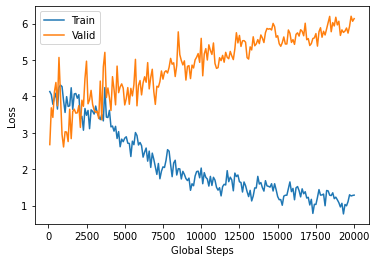

In [ ]:
draw_graph(output_file_path, on_device)